<a href="https://colab.research.google.com/github/Ghzraza/multiomic_network_simulation/blob/main/Interspieces_module_alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains:
1- Interspecies Moldule Alignent
2- Ai Based modeling for important modules
3- Visualization for integrated omics data

In [1]:
# Simulate & export example multi-omic CSVs ----------
# Paste into Colab / Jupyter and run.

!pip install --quiet numpy pandas

import numpy as np, pandas as pd
np.random.seed(42)

def simulate_rna(n_cells, n_genes, seed=0, dropout=0.12):
    rng = np.random.default_rng(seed)
    means = rng.lognormal(mean=1.0, sigma=0.8, size=n_genes)
    counts = np.zeros((n_cells, n_genes), dtype=int)
    dispersion = 1.0
    for g, mu in enumerate(means):
        p = dispersion / (dispersion + mu)
        counts[:, g] = rng.negative_binomial(dispersion, p, size=n_cells)
    counts[rng.random(counts.shape) < dropout] = 0
    cols = [f"GENE_{i+1}" for i in range(n_genes)]
    idx = [f"cell_{i+1}" for i in range(n_cells)]
    return pd.DataFrame(counts, index=idx, columns=cols)

def simulate_prot(n_cells, n_proteins, seed=1):
    rng = np.random.default_rng(seed)
    mat = rng.lognormal(mean=1.0, sigma=0.7, size=(n_cells, n_proteins))
    return pd.DataFrame(mat, index=[f"cell_{i+1}" for i in range(n_cells)],
                        columns=[f"PROT_{i+1}" for i in range(n_proteins)])

def simulate_meth(n_cells, n_sites, seed=2):
    rng = np.random.default_rng(seed)
    a = rng.uniform(1.5, 3.5, n_sites); b = rng.uniform(2.0, 6.0, n_sites)
    mat = np.column_stack([rng.beta(a[i], b[i], size=n_cells) for i in range(n_sites)])
    return pd.DataFrame(mat, index=[f"cell_{i+1}" for i in range(n_cells)],
                        columns=[f"METH_{i+1}" for i in range(n_sites)])

n_cells = 200
human_rna = simulate_rna(n_cells, 800, seed=10)
human_prot = simulate_prot(n_cells, 120, seed=11)
human_meth = simulate_meth(n_cells, 200, seed=12)
# metadata
rng = np.random.default_rng(10)
meta = pd.DataFrame({
    "cell_id": human_rna.index,
    "sample_id": rng.integers(1,10,n_cells),
    "sex": rng.choice(["M","F"], size=n_cells),
    "phenotype": rng.choice(["control","stress"], size=n_cells, p=[0.6, 0.4])
}).set_index("cell_id")

# Mouse (rename genes to ortholog-like MGENE_)
mouse_rna = simulate_rna(n_cells, 800, seed=20)
mouse_rna.columns = [c.replace("GENE_", "MGENE_") for c in mouse_rna.columns]
mouse_prot = simulate_prot(n_cells, 120, seed=21)
mouse_meth = simulate_meth(n_cells, 200, seed=22)
rng2 = np.random.default_rng(20)
mouse_meta = pd.DataFrame({
    "cell_id": mouse_rna.index,
    "sample_id": rng2.integers(1,8,n_cells),
    "sex": rng2.choice(["M","F"], size=n_cells),
    "phenotype": rng2.choice(["control","stress"], size=n_cells)
}).set_index("cell_id")

# Save CSVs
human_rna.to_csv("human_rna.csv")
human_prot.to_csv("human_prot.csv")
human_meth.to_csv("human_meth.csv")
meta.to_csv("human_meta.csv")

mouse_rna.to_csv("mouse_rna.csv")
mouse_prot.to_csv("mouse_prot.csv")
mouse_meth.to_csv("mouse_meth.csv")
mouse_meta.to_csv("mouse_meta.csv")

print("Saved example CSVs: human_*.csv and mouse_*.csv")


Saved example CSVs: human_*.csv and mouse_*.csv


Data loaded: (200, 800) (200, 800)
Running pseudo-WGCNA on human ...


/tmp/ipython-input-4094828650.py:25: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(pairwise_distances(df.T, metric='correlation'), method='average')


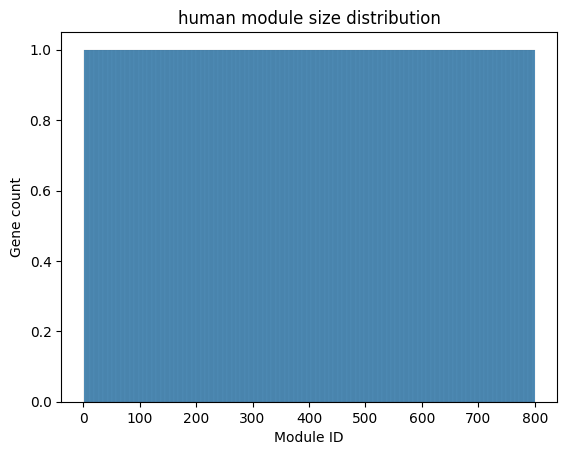

Saved human_modules.csv with 800 genes.
Running pseudo-WGCNA on mouse ...


/tmp/ipython-input-4094828650.py:25: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = linkage(pairwise_distances(df.T, metric='correlation'), method='average')


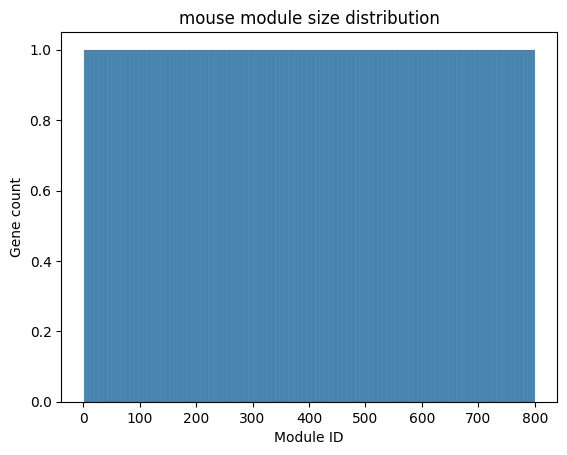

Saved mouse_modules.csv with 800 genes.
✅ Done. Files saved: human_modules.csv, mouse_modules.csv


In [3]:
# ---------- WGCNA_Module_Generator ----------

!pip install --quiet pandas numpy scipy scikit-learn matplotlib seaborn networkx

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, fcluster
import networkx as nx

# ---------- Load Data ----------
human = pd.read_csv("human_rna.csv", index_col=0)
mouse = pd.read_csv("mouse_rna.csv", index_col=0)
print("Data loaded:", human.shape, mouse.shape)

# ---------- Define helper: simple WGCNA-like function ----------
def run_wgcna_like(df, species="human", power=6, min_cluster_size=20):
    print(f"Running pseudo-WGCNA on {species} ...")

    # Compute correlation matrix
    corr = df.corr().fillna(0)
    adj = np.power(np.abs(corr), power)

    # Compute dissimilarity
    diss = 1 - adj
    link = linkage(pairwise_distances(df.T, metric='correlation'), method='average')

    # Flat cluster cut
    cluster_ids = fcluster(link, t=1.15, criterion='distance')
    modules = pd.Series(cluster_ids, index=df.columns, name="module")

    # Visualize dendrogram-level summary
    sns.histplot(modules, bins=len(np.unique(cluster_ids)))
    plt.title(f"{species} module size distribution")
    plt.xlabel("Module ID"); plt.ylabel("Gene count")
    plt.show()

    # Save module assignments
    modules.to_csv(f"{species}_modules.csv")
    print(f"Saved {species}_modules.csv with {len(modules)} genes.")
    return modules

# ---------- Run for both species ----------
human_modules = run_wgcna_like(human, species="human", power=6)
mouse_modules = run_wgcna_like(mouse, species="mouse", power=6)

print("✅ Done. Files saved: human_modules.csv, mouse_modules.csv")


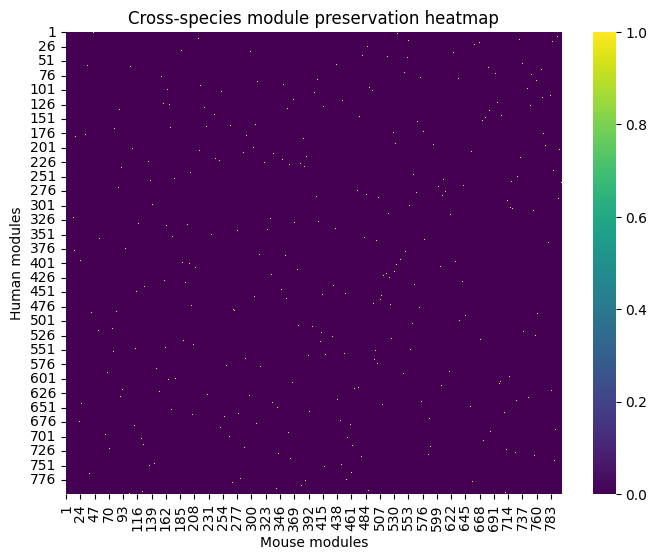

✅ Saved: module_preservation_scores.csv


,human_module,preservation_score
0,784,1.0
1,783,1.0
2,782,1.0
3,781,1.0
4,780,1.0


In [4]:
# ---------- Interspecies_Module_Alignment ----------

!pip install --quiet pandas numpy seaborn matplotlib

import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

# ---------- Load previous results ----------
human_mod = pd.read_csv("human_modules.csv", index_col=0)
mouse_mod = pd.read_csv("mouse_modules.csv", index_col=0)

# ---------- Create ortholog map ----------
# Simulated data: one-to-one mapping (GENE_1 <-> MGENE_1)
ortholog_map = pd.DataFrame({
    "human_gene": [f"GENE_{i+1}" for i in range(len(human_mod))],
    "mouse_gene": [f"MGENE_{i+1}" for i in range(len(mouse_mod))]
})

# Merge module assignments
merged = ortholog_map.merge(human_mod, left_on="human_gene", right_index=True)
merged = merged.merge(mouse_mod, left_on="mouse_gene", right_index=True, suffixes=("_human", "_mouse"))

# ---------- Compute overlap matrix ----------
overlap = pd.crosstab(merged["module_human"], merged["module_mouse"])

# ---------- Normalize for preservation score ----------
preservation = overlap.div(overlap.sum(axis=1), axis=0)

# ---------- Plot heatmap ----------
plt.figure(figsize=(8,6))
sns.heatmap(preservation, cmap="viridis", annot=False)
plt.title("Cross-species module preservation heatmap")
plt.xlabel("Mouse modules")
plt.ylabel("Human modules")
plt.show()

# ---------- Compute top preserved modules ----------
pres_scores = preservation.max(axis=1)
pres_df = pres_scores.sort_values(ascending=False).reset_index()
pres_df.columns = ["human_module", "preservation_score"]
pres_df.to_csv("module_preservation_scores.csv", index=False)

print("✅ Saved: module_preservation_scores.csv")
display(pres_df.head())


RF classification report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        23
           1       0.00      0.00      0.00        17

    accuracy                           0.57        40
   macro avg       0.29      0.50      0.37        40
weighted avg       0.33      0.57      0.42        40

RF AUC: 0.3516624040920716
Saved rf_top_feature_importances.csv


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


XGBoost classification report:
              precision    recall  f1-score   support

           0       0.57      0.70      0.63        23
           1       0.42      0.29      0.34        17

    accuracy                           0.53        40
   macro avg       0.49      0.49      0.49        40
weighted avg       0.51      0.53      0.51        40

Saved models: rf_model.joblib and xgb_model.json


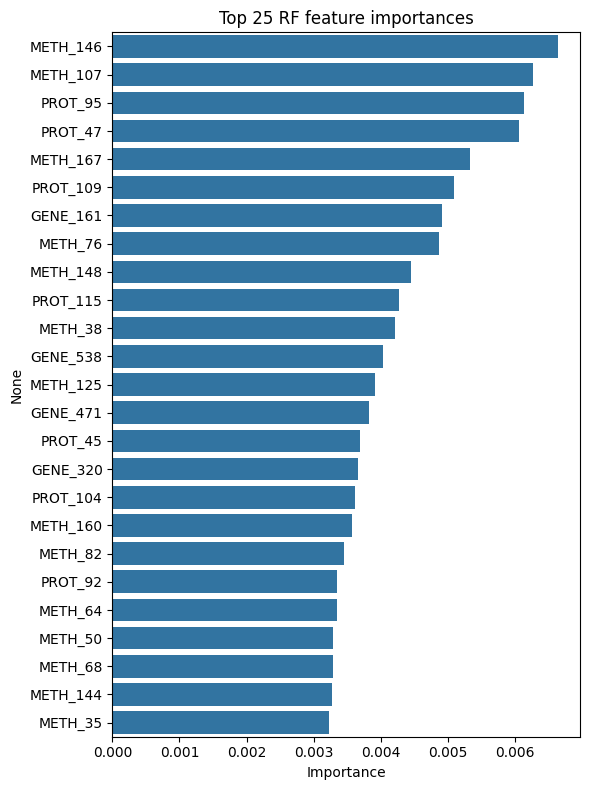

In [5]:
# ---------- Notebook 3: AI modeling (Python) ----------
!pip install --quiet numpy pandas scikit-learn xgboost joblib matplotlib seaborn

import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
import joblib, os
import matplotlib.pyplot as plt, seaborn as sns

# Load processed CSVs (assumes same cell ordering in human_* CSVs)
rna = pd.read_csv("human_rna.csv", index_col=0)
prot = pd.read_csv("human_prot.csv", index_col=0)
meth = pd.read_csv("human_meth.csv", index_col=0)
meta = pd.read_csv("human_meta.csv", index_col=0)

# Optional: perform feature selection: pick top variable genes/proteins/sites
def top_n_by_var(df, n):
    return df.loc[:, df.var(axis=0).sort_values(ascending=False).head(n).index]

rna_sel = top_n_by_var(rna, 1000)   # genes
prot_sel = top_n_by_var(prot, 150)  # proteins
meth_sel = top_n_by_var(meth, 200)  # methylation sites

# Standardize / transform and concatenate
rna_f = np.log1p(rna_sel)
sc_rna = StandardScaler().fit_transform(rna_f)
sc_prot = StandardScaler().fit_transform(np.log1p(prot_sel))
sc_meth = StandardScaler().fit_transform(meth_sel)
X = np.concatenate([sc_rna, sc_prot, sc_meth], axis=1)
feature_names = list(rna_sel.columns) + list(prot_sel.columns) + list(meth_sel.columns)
X = pd.DataFrame(X, index=rna_sel.index, columns=feature_names)

# Prepare labels (binary)
y = meta.loc[X.index, "phenotype"].map({"control":0, "stress":1}).astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
prob = rf.predict_proba(X_test)[:,1]
print("RF classification report:")
print(classification_report(y_test, pred))
try:
    print("RF AUC:", roc_auc_score(y_test, prob))
except:
    pass

# Feature importances
fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
fi.head(30).to_csv("rf_top_feature_importances.csv")
print("Saved rf_top_feature_importances.csv")

# XGBoost (optional)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {"objective":"binary:logistic", "eval_metric":"auc", "eta":0.1, "max_depth":4}
bst = xgb.train(params, dtrain, num_boost_round=150, evals=[(dtest, "test")], verbose_eval=False)
pred_x = (bst.predict(dtest) > 0.5).astype(int)
print("XGBoost classification report:")
print(classification_report(y_test, pred_x))

# Save models
joblib.dump(rf, "rf_model.joblib")
bst.save_model("xgb_model.json")
print("Saved models: rf_model.joblib and xgb_model.json")

# Plot top features
plt.figure(figsize=(6,8))
sns.barplot(x=fi.iloc[:25].values, y=fi.iloc[:25].index)
plt.title("Top 25 RF feature importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig("rf_top25_features.png", dpi=150)
plt.show()


Data loaded: (200, 800) (200, 120) (200, 200)


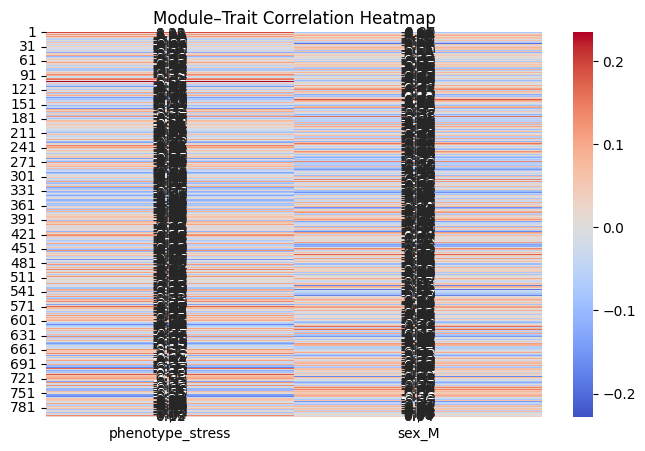

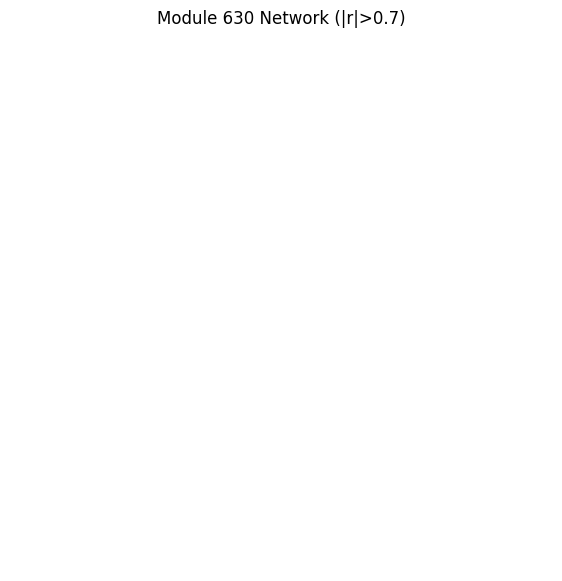

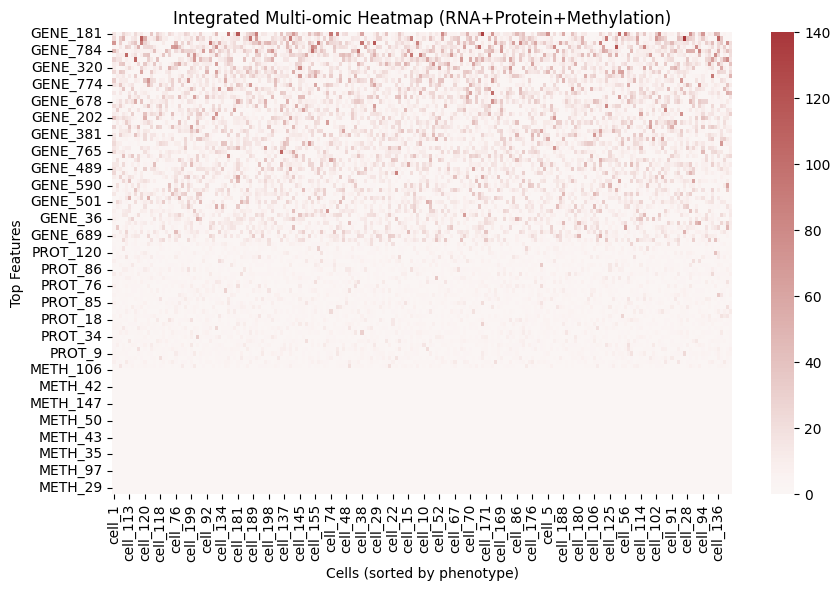

In [7]:
# ---------- Notebook 4: Visualization and Multi-omic Integration ----------

!pip install --quiet pandas numpy matplotlib seaborn networkx scipy

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, networkx as nx
from scipy.stats import pearsonr

# ---------- Load data ----------
human_rna = pd.read_csv("human_rna.csv", index_col=0)
human_meta = pd.read_csv("human_meta.csv", index_col=0)
human_modules = pd.read_csv("human_modules.csv", index_col=0)
human_prot = pd.read_csv("human_prot.csv", index_col=0)
human_meth = pd.read_csv("human_meth.csv", index_col=0)

print("Data loaded:", human_rna.shape, human_prot.shape, human_meth.shape)

# ---------- 1️⃣ Compute module eigengenes ----------
def compute_module_eigengenes(expr_df, modules):
    eigengenes = {}
    for m in np.unique(modules):
        genes = modules[modules == m].index
        sub = expr_df[genes]
        eigengenes[m] = sub.mean(axis=1)
    return pd.DataFrame(eigengenes, index=expr_df.index)

eigengenes = compute_module_eigengenes(human_rna, human_modules["module"])
eigengenes.head()

# ---------- 2️⃣ Module–Trait correlations ----------
traits = pd.get_dummies(human_meta[["phenotype","sex"]], drop_first=True)
corr_mat = pd.DataFrame(index=eigengenes.columns, columns=traits.columns, dtype=float)
pval_mat = corr_mat.copy()

for mod in eigengenes.columns:
    for trait in traits.columns:
        r, p = pearsonr(eigengenes[mod], traits[trait])
        corr_mat.loc[mod, trait] = r
        pval_mat.loc[mod, trait] = p

plt.figure(figsize=(8,5))
sns.heatmap(corr_mat, cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Module–Trait Correlation Heatmap")
plt.show()

# ---------- 3️⃣ Network graph of a chosen module ----------
target_module = int(corr_mat.abs().mean(axis=1).idxmax())  # module most linked to traits
genes = human_modules[human_modules["module"]==target_module].index
sub_corr = human_rna[genes].corr()

# Create network
G = nx.Graph()
for g1 in genes:
    for g2 in genes:
        if g1!=g2 and abs(sub_corr.loc[g1,g2])>0.7:
            G.add_edge(g1, g2, weight=sub_corr.loc[g1,g2])

plt.figure(figsize=(7,7))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=80, node_color='skyblue')
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=6)
plt.title(f"Module {target_module} Network (|r|>0.7)")
plt.axis('off')
plt.show()

# ---------- 4️⃣ Integrated multi-omic heatmap ----------
# Select top 50 variable features from each omic
top_rna = human_rna.var(axis=0).nlargest(50).index
top_prot = human_prot.var(axis=0).nlargest(30).index
top_meth = human_meth.var(axis=0).nlargest(30).index

integrated = pd.concat([
    human_rna[top_rna],
    human_prot[top_prot],
    human_meth[top_meth]
], axis=1)

# Sort by phenotype
ordered = integrated.loc[human_meta.sort_values("phenotype").index]
plt.figure(figsize=(10,6))
sns.heatmap(ordered.T, cmap="vlag", center=0)
plt.title("Integrated Multi-omic Heatmap (RNA+Protein+Methylation)")
plt.xlabel("Cells (sorted by phenotype)")
plt.ylabel("Top Features")
plt.show()
